# Week 2

**`Agent::API::base`**
* `fit` method
* private API (agent-specific)
* public API (environment runner friendly)

**`Environment::API::runner`**
* fixed agent API
* multiple episodes

In [1]:
# change current working directory
%cd ..

/Users/alpha/Developer/qtrader


In [2]:
# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# trading environment
from qtrader.envs import TradingEnv

# YAML parser
import yaml

# OpenAI Gym
import gym

# # visualization
import matplotlib.pyplot as plt

In [3]:
# fetch configuration file
config = yaml.load(open('config/log/week_2.yaml', 'r'))

# configuration summary
print(f"start date: {config['start_date']}")
print(f"trading frequency: {config['freq']}")
print(f"trading universe: {config['tickers']}")
print(f"number of episodes: {config['num_episodes']}")

start date: 2017-01-01
trading frequency: W-FRI
trading universe: ['AAPL', 'GE', 'JPM']
number of episodes: 100


### Trading Environment

Initialize a trading environment, with which the agents will interact.

In [4]:
# initialize environment
env = TradingEnv(universe=config['tickers'],
                 trading_period=config['freq'],
                 csv=config['csv_file_prices'])

## `Agent`

Base class for agents that complies with interface for automatic execution of environment.
* **private**: agent-specific methods
* **public**: API accessed by the `run` method

In [5]:
class Agent:
    """Base class for agents in OpenAI Gym
    compatible environments."""

    _id = 'base'

    def __init__(self, **kwargs):
        raise NotImplementedError

    #######
    # API
    #######

    @property
    def name(self):
        return self._id

    def begin_episode(self, observation):
        pass

    def act(self, observation):
        raise NotImplementedError

    def observe(self, observation, action, reward, done, next_observation):
        pass

    def end_episode(self):
        pass
    
    def fit(self, env, num_episodes=1, verbose=False):
        return run(env, self, num_episodes, True, verbose)

### `RandomAgent`

Example random agent, implementing the common interface.
Suitable to implement `act` method only.

In [6]:
class RandomAgent(Agent):
    """Random agent."""

    _id = 'random'

    def __init__(self, action_space):
        self.action_space = action_space

    #######
    # API
    #######

    def act(self, observation):
        """Randomly sample an action
        from action space."""
        return self.action_space.sample()

## `run`

OpenAI gym environments automated execution runner.

In [7]:
def run(env, agent, num_episodes, record, log):
    """Run episode on the `env` using `agent`.

    Parameters
    ----------
    env: gym.Env
        OpenAI Gym compatible environment
    agent: qtrader.agent.base.Agent
        Agent to interact with the environment
    num_episodes: int
        Number of episodes to run
    record: bool
        Keep record of actions & rewards for each step
    log: bool
        Flag for logging at the end of each episode

    Returns
    -------
    rewards: list
        List of rewards per step per episode
    actions: list
        List of actions per step per episode
    """
    # unregister all agents from environment
    if hasattr(env, 'unregister'):
        # when agent=None, all agents unregistered
        env.unregister(agent=None)
    # register agent to environment if needed
    if hasattr(env, 'register'):
        # assign random name if not given
        if not hasattr(agent, 'name'):
            agent.name = '_default'
        # register agent, duplicates are ignored
        env.register(agent)
    # initialize rewards buffer
    rewards = []
    # initialize actions buffer
    actions = []

    def _run():
        """Closure runner for each episode."""
        # initialize rewards local buffer
        _rewards = []
        # initialize actions local buffer
        _actions = []
        # environment: reset & fetch observation
        ob = env.reset()
        # initialize reward
        reward = 0.0
        # termination flag
        done = False
        # environment state information
        info = {}
        # iterator for maximum episode steps
        j = 0
        # agent closure: beginning of episode
        agent.begin_episode(ob)
        # interaction loop
        while (not done) and (j < env._max_episode_steps):
            # agent closure: determine action
            action = agent.act(ob)
            # class 1: trading environments
            if hasattr(env, 'register'):
                # environment: take action
                ob_, reward, done, info = env.step({agent.name: action})
                # fetch agent-specific reward
                reward = reward[agent.name]
            # class 2: vanilla environments
            else:
                # environment: take action
                ob_, reward, done, info = env.step(action)
            # store reward
            _rewards.append(reward)
            # store action
            _actions.append(action)
            # agent closure: observe
            agent.observe(ob, action, reward, done, ob_)
            # set new observation to current
            ob = ob_
            # increment iterator
            j = j + 1
        # agent closure: end of episode
        agent.end_episode()
        return _rewards, _actions

    for e in range(num_episodes):
        # run episode
        R, A = _run()
        # episode-wise records
        if record:
            # store rewards
            rewards.append(R)
            # store actions
            actions.append(A)
        # log cumulative rewards
        if log:
            print('episode: %4d, cumulative reward: %+.5f' % (e, sum(R)))
    return rewards, actions

### Experiments

Combine `RandomAgent` and `run` on a common OpenAI environment, the **`CartPole-v1`**,
and on the custom trading environment, the **`TradingEnv`**.

#### `CartPole-v1`

In [8]:
# initialize environment
env = gym.make('CartPole-v1')
# initialize agent
agent = RandomAgent(env.action_space)
# execute environment
rewards, actions = run(env, agent, config['num_episodes'], True, False)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


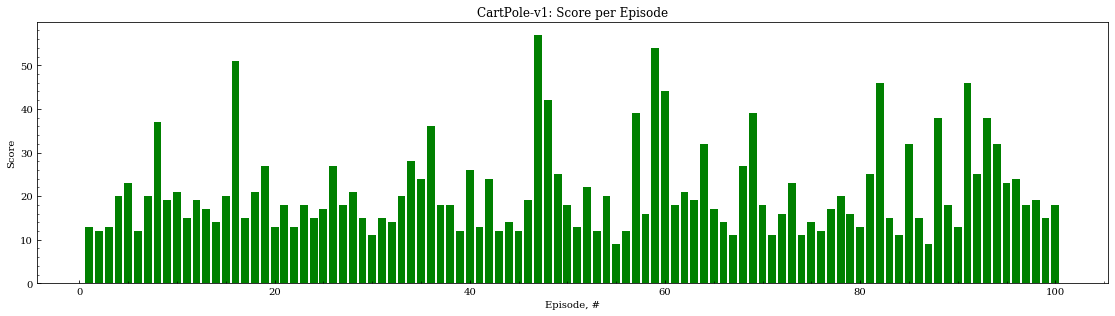

In [9]:
# initialize figure & axes
fig, axes = plt.subplots(figsize=(19.2, 4.8))
# plot cumulative reward per-episode
for j in range(len(rewards)):
    axes.bar(j+1, sum(rewards[j]), color='g')
# axes settings
axes.set(title='CartPole-v1: Score per Episode', ylabel='Score', xlabel='Episode, #');

#### `TradingEnv`

In [10]:
# initialize environment
env = TradingEnv(universe=config['tickers'],
                 trading_period=config['freq'],
                 start_date=config['start_date'],
                 csv=config['csv_file_prices'])
# initialize agent
agent = RandomAgent(action_space=env.action_space)
# execute environment
rewards, actions = run(env, agent, config['num_episodes'], True, False)

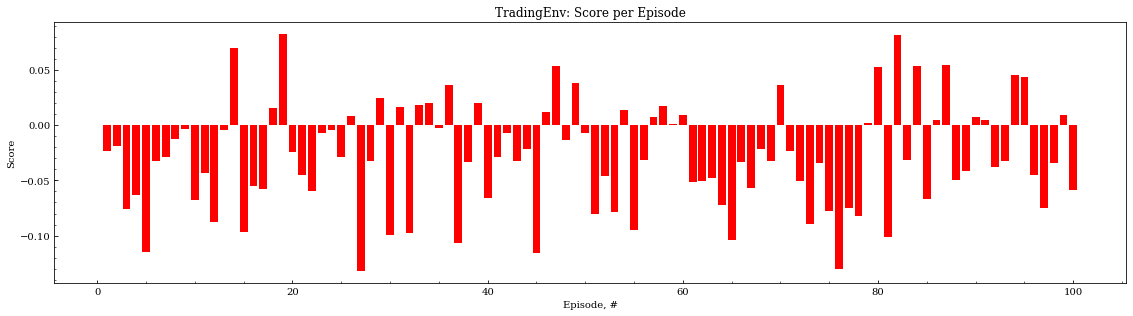

In [11]:
# initialize figure & axes
fig, axes = plt.subplots(figsize=(19.2, 4.8))
# plot cumulative reward per-episode
for j in range(len(rewards)):
    axes.bar(j+1, sum(rewards[j]), color='r')
# axes settings
axes.set(title='TradingEnv: Score per Episode', ylabel='Score', xlabel='Episode, #');

## `agent.fit`

Following `scikit-learn` API, the agent base class has a method **`fit`** which calls `run`
internally for training the agent. The method can be reimplemented by derived agents.

In [12]:
# initialize environment
env = gym.make('CartPole-v1')
# initialize agent
agent = RandomAgent(env.action_space)
# execute environment
rewards, actions = agent.fit(env, config['num_episodes'])

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


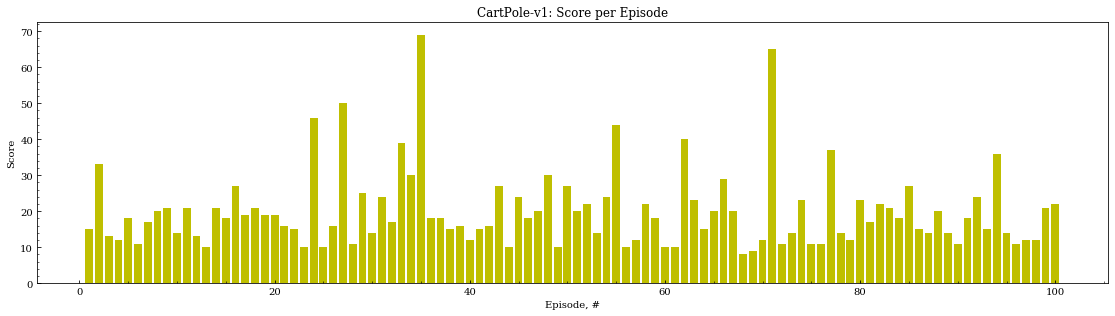

In [13]:
# initialize figure & axes
fig, axes = plt.subplots(figsize=(19.2, 4.8))
# plot cumulative reward per-episode
for j in range(len(rewards)):
    axes.bar(j+1, sum(rewards[j]), color='y')
# axes settings
axes.set(title='CartPole-v1: Score per Episode', ylabel='Score', xlabel='Episode, #');